In [ ]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
!pip install pillow tensorflow keras --quiet

In [4]:

# ------------------------------
# Parameters
# ------------------------------
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20


In [5]:

# ------------------------------
# Load Dataset
# ------------------------------
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",   # 👈 your parent dataset folder
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print("Classes:", class_names)  
# should print: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


Found 4217 files belonging to 4 classes.


2025-08-21 21:15:12.754341: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-08-21 21:15:12.754493: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-21 21:15:12.754504: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-08-21 21:15:12.754691: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-21 21:15:12.754734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [6]:

# ------------------------------
# Train / Val / Test Split (80/10/10)
# ------------------------------
train_size = int(0.8 * len(dataset))
val_size   = int(0.1 * len(dataset))
test_size  = int(0.1 * len(dataset))

train_ds = dataset.take(train_size)
val_ds   = dataset.skip(train_size).take(val_size)
test_ds  = dataset.skip(train_size + val_size).take(test_size)

print("Train batches:", len(train_ds))
print("Val batches:", len(val_ds))
print("Test batches:", len(test_ds))


Train batches: 105
Val batches: 13
Test batches: 13


In [7]:

# ------------------------------
# Prefetch (for performance on M2 GPU)
# ------------------------------
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


2025-08-21 21:15:16.097544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


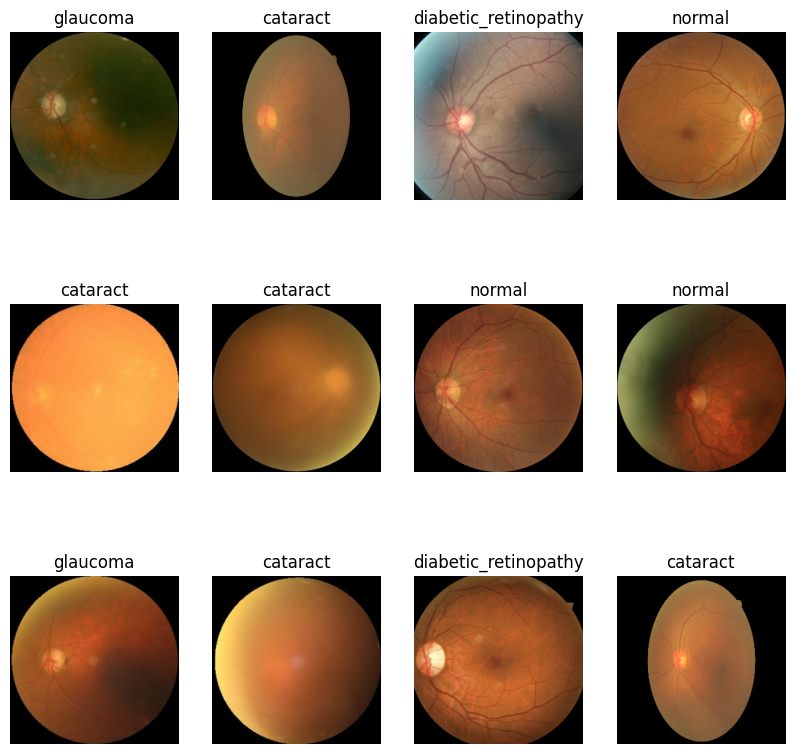

In [8]:

# ------------------------------
# Visualize Some Images
# ------------------------------
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


In [9]:

# ------------------------------
# Build Model (MobileNetV2 Transfer Learning)
# ------------------------------
base_model = MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze backbone

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


/var/folders/dj/085sd8h16bb0kcrgxykk6ctm0000gn/T/ipykernel_3777/1147379145.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:

# ------------------------------
# Train Model
# ------------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/20


2025-08-21 21:15:21.637210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 197ms/step - accuracy: 0.6000 - loss: 1.2000 - val_accuracy: 0.7644 - val_loss: 0.5600
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.7247 - loss: 0.8512 - val_accuracy: 0.8077 - val_loss: 0.4810
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.7443 - loss: 0.7557 - val_accuracy: 0.8077 - val_loss: 0.5024
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.7848 - loss: 0.6079 - val_accuracy: 0.8293 - val_loss: 0.4359
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - accuracy: 0.7801 - loss: 0.5973 - val_accuracy: 0.8462 - val_loss: 0.3995
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.8092 - loss: 0.5214 - val_accuracy: 0.8534 - val_loss: 0.3850
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.8188 - loss: 0.4829 - val_accuracy: 0.8486 - val_loss: 0.3968
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.8283 - loss: 0.4527 - val

In [11]:

# ------------------------------
# Evaluate on Test Set
# ------------------------------
test_loss, test_acc = model.evaluate(test_ds)
print("✅ Test accuracy:", test_acc)


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.8558 - loss: 0.3686
✅ Test accuracy: 0.8557692170143127


In [12]:

# ------------------------------
# Save Model
# ------------------------------
model.save("eye_disease_mobilenetv2.h5")
print("✅ Model saved as eye_disease_mobilenetv2.h5")


✅ Model saved as eye_disease_mobilenetv2.h5


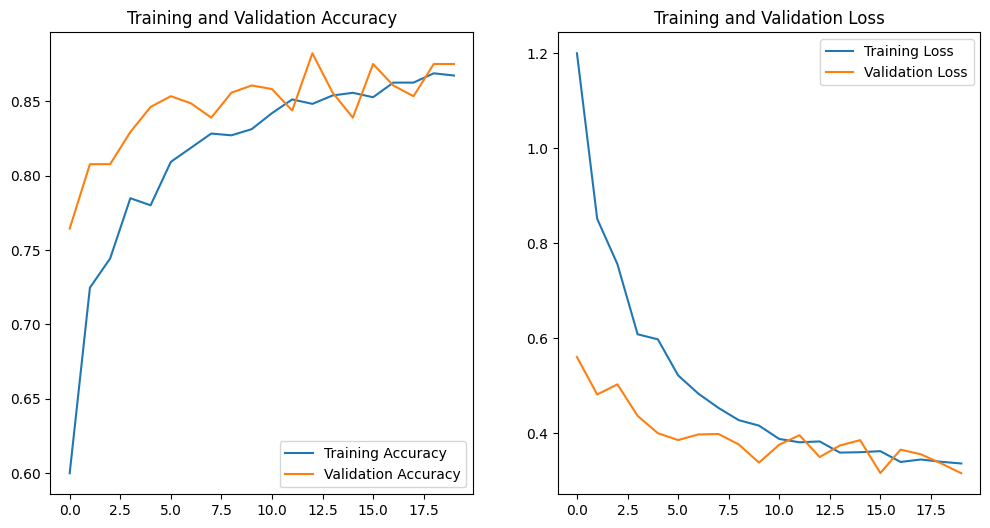

In [13]:

# ------------------------------
# Plot Training Curves
# ------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [1]:

# ------------------------------
# Prediction Example
# ------------------------------
from tensorflow.keras.preprocessing import image

img_path = "test_eye.jpg"   # replace with your test image path
img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

pred = model.predict(img_array)
pred_class = class_names[np.argmax(pred)]
print("🔮 Predicted:", pred_class)


NameError: name 'IMAGE_SIZE' is not defined